## Structure prediction of copper phosphides

### Abstract

Transition-metal phosphides represent a class of materials with uses throughout the renewable energy field especially in the areas of hydrogen evolution reactions and as Li-ion battery conversion anodes.  In the case of Li-ion batteries, the transition metal copper is especially of interest as it is the current collector for most modern Li ion batteries, and Cu$_3$P is a well studied conversion anode in both Li and Na-ion batteries. Thus, through a two-step structure prediction method, stable structures at high temperature and pressure have been identified and characterised by density-functional theory (DFT) calculations.  This study highlights a novel $F$m$\bar{3}$m phase of Cu$_2$P, which has a higher gravimetric capacity of 508 mAh/g, compared to the known conversion anode Cu$_3$P which has experimentally shown capacities up to 415 mAh/g. Additionally, DFT geometry optimisations predict the $I$4/mmm phase of Cu$_2$P to be stable up to 50 GPa, and thermodynamic predictions from the DFT zero-point energy predict $F$m$\bar{3}$m Cu$_2$P to be stable at temperatures up to 430 K. Furthermore, crystal structure prediction at elevated pressures up to 10 GPa shows that the copper-rich phases which contain 6 and 9-fold coordinated phosphorus become more stable at elevated pressures, a trend confirmed in other transition-metal phosphide phases.  These first-principles predictions of the stable Cu$_2$P phase as well as other meta-stable high-pressure phases highlight the need to further explore this phase diagram experimentally, in order to determine which phases are synthesizable, and represents the first direct prediction of a new high-capacity Li-ion battery conversion anode which is more energetically stable than Cu$_3$P.  

### Imports

In [1]:
from matador.config.config import set_settings
set_settings(
    {
        'plotting': {
            'element_colours': './config/vesta_elements.ini',
            'default_style': ['matador', './config/CuP.mplstyle']
        }
    }
)

In [2]:
import warnings
warnings.filterwarnings('ignore')

import tqdm
import glob
import pickle
from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.hull import EnsembleHull
from matador.scrapers import castep2dict, res2dict
from matador.utils.cursor_utils import filter_unique_structures
from matador.utils.cell_utils import standardize_doc_cell, get_spacegroup_spg
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
# ME: revert to png here for now to save space
set_matplotlib_formats('png')

### Results

### Structure prediction step

In [3]:
# load AIRSS structures obtained from searching (old)
cursor, failures = res2dict('/u/fs1/afh41/hull-CuP-afh41-CuP/*.res', db=True)
if failures:
    print(failures)
    
# load AIRSS structures obtained from searching
cursor=[]
hullstructs,failures = res2dict('/u/fs1/afh41/hull-CuP-afh41-CuP1/*.res', db=True)
config_enum, failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/config*res', db=True)
ga, failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/*-GA-*res',db=True)
airss2019,failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/airss-2019/*/*res',db=True)
swaps2019,failures = res2dict('/u/fs1/afh41/proj/Cu+P/300-0.05-PBE-00PBE_CuP/swaps-2019/*res',db=True)

cursor = hullstructs + airss2019 + swaps2019 + config_enum + ga


In [4]:
# do some pruning: reevaluate symmetries and reduce cells
cursor = [standardize_doc_cell(doc, ) for doc in cursor]
for doc in cursor:
    doc['space_group'] = get_spacegroup_spg(doc, symprec=0.1)

In [5]:
# filter them for uniqueness
filtering = False
if filtering:
    cursor = filter_unique_structures(cursor)

In [6]:
hull = QueryConvexHull(
    cursor=cursor, 
    species=['Cu', 'P'], 
    no_plot=True, 
    uniq=False, 
    source=True
)

7 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0[..]              0.03       11.3          0.0    Fm-3m          Cu          1      ICSD  
           └────────────────── /u/fs1/afh41/hull-CuP-afh41-CuP1/Cu-OQMD_592441-CollCode43493_0.06A.res
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* CuP-aw2v56-a_final                              0.04       19.8          0.0    Fm-3m         Cu2P         2     AIRSS 

Using config from /u/fs1/afh41/.matadorrc


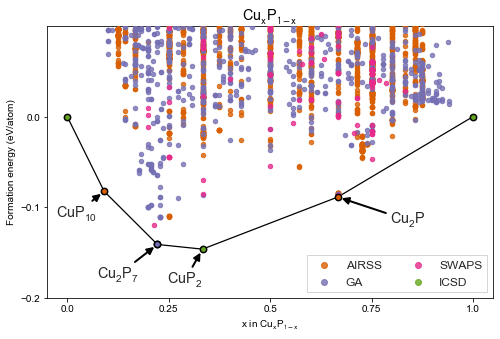

In [7]:
from matador.plotting import plot_2d_hull
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 5))
ax = plot_2d_hull(
    hull,
    ax=ax,
    label_cutoff=8e-3, 
    colour_by_source=True,
    plot_hull_points=False,
    show=False,
    alpha=0.8, 
    label_offset=(1.15, 0.02),
    eform_limits=(-0.2, 0.1),
    sources=['ICSD', 'MP', 'SWAPS', 'OQMD', 'GA', 'AIRSS']
)
ax.set_yticks([-0.2, -0.1, 0])
plt.show()
# plt.savefig('CuP-convex-hull.png',bbox_inches='tight',transparent=True)

### Li-Cu-P ternary

In [42]:
cursor, failures = res2dict('/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/*.res', db=True)

if failures:
    print(failures)

In [54]:
# This is the ternary hull used to create the voltage profiles. It has ommitted the disputed Cu-Li
# phases and the high P content Cu-P phases to identify specifically the Cu3P and Cu2P voltage profiles

hull = QueryConvexHull(cursor=cursor,
        #expt='Cu3P-deetrizio-exp.csv',
        #expt='Cu3P-expt-voltage-bichat2004electrochemical.csv',
        expt='/u/fs1/afh41/voltage-LiCuP-afh41-LiCuP-noCu2P/Cu3P-expt-voltage-bichat2004electrochemicalC8.csv',
        expt_label='Cu$_3$P experimental Bichat et al (2004)',
        no_plot=True,
        capmap=True,
        pathways=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

13 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0                  0.07       11.3          0.0    Fm-3m          Cu          1      ICSD  
* CuP-aw2v56-a_final                              0.04       39.5          0.0    Imm2          Cu2P         2     AIRSS  
* Cu2LiP2-OQMD_2275-CollCode2734                  0.01       69.5          0.0   I4/mmm        Cu2LiP2       1      ICSD  
* Cu4Li5P6-OQMD_33279-CollCode2735                0.05      206.9          0.0    Immm        Cu4Li5P

In [55]:
# remove Cu2P from the plot and calculate the convex hull without Cu2P
from matador.utils.chem_utils import get_formula_from_stoich
noCu2Pcursor = []
for item in cursor:
    if get_formula_from_stoich(item['stoichiometry']) != 'Cu2P':
        noCu2Pcursor.append(item)
        
hullnoCu2P = QueryConvexHull(cursor=noCu2Pcursor,
        no_plot=True,
        subcmd='voltage', 
        elements=['Li', 'Cu', 'P'])

Something fishy with height above plane, returning 0...
0.0 0.0 0.0
[ 0.01140906  0.         -0.        ]
13 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0                  0.07       11.3          0.0    Fm-3m          Cu          1      ICSD  
* CuP-GA-m0ol1y-9x19                              0.01       50.8          0.0     P1           Cu3P         2       GA   
* Cu2LiP2-OQMD_2275-CollCode2734                  0.01       69.5          0.0   I4/mmm        Cu2LiP2       1      IC

In [56]:
from matador.plotting import plot_voltage_curve
# revert to matador colourscheme
set_settings({'plotting': {'default_style': 'matador'}})

Using config from /u/fs1/me388/.matadorrc
Using config from /u/fs1/me388/.matadorrc


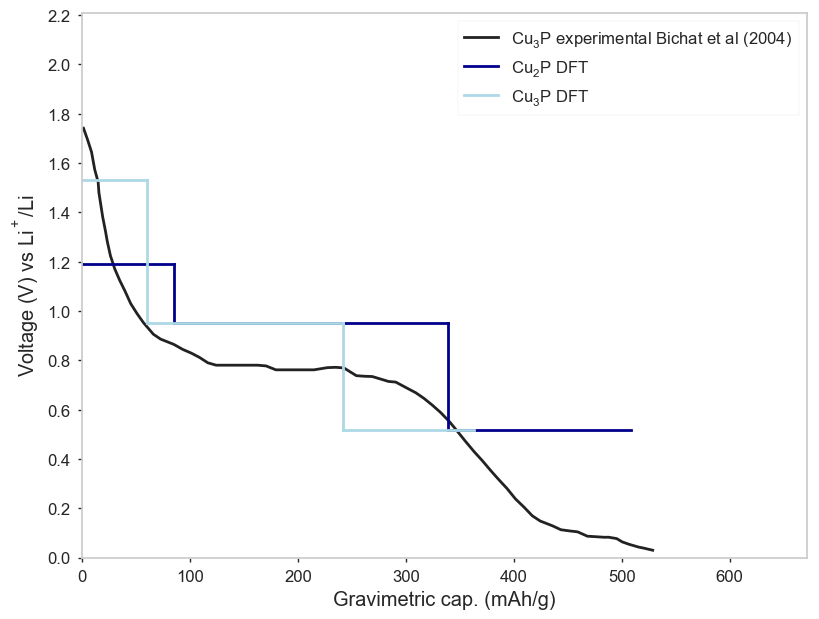

In [57]:
fig, ax = plt.subplots()
ax = plot_voltage_curve(hull, 
                        ax=ax, curve_label='Cu$_2$P DFT', 
                        line_kwargs={'ls': '-', 'color': 'darkblue'})
ax = plot_voltage_curve(hullnoCu2P, 
                        ax=ax, curve_label='Cu$_3$P DFT', 
                        line_kwargs={'ls': '-', 'color': 'lightblue'})
ax.legend()

Using config from /u/fs1/me388/.matadorrc
Reordering bands based on local gradients...
Displaying plot...


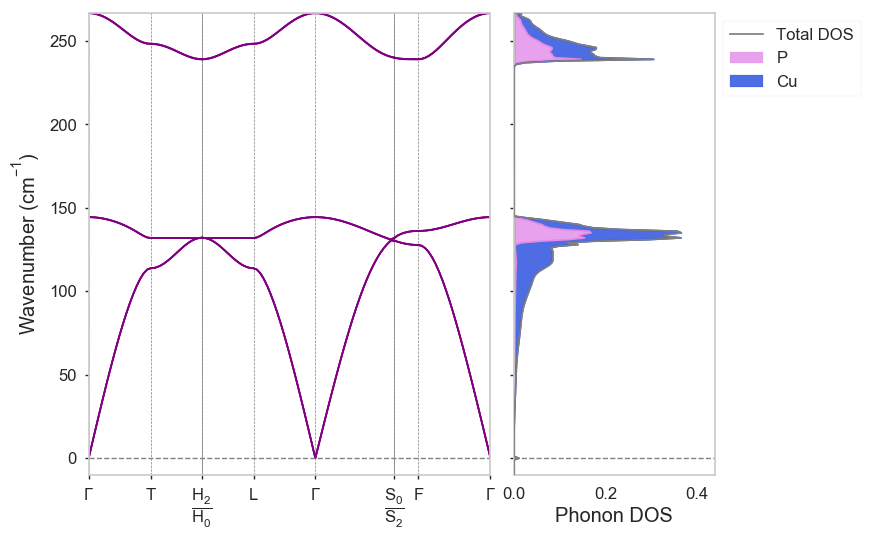

In [58]:
from matador.plotting import plot_spectral
ax = plot_spectral(
    '/u/fs1/afh41/Cu2P-phonon-correct-path/CuP-Ir2P-OQMD_30622-CollCode640898', 
    phonons=True,
    band_colour='purple', 
  #  png=True
)

Using config from /u/fs1/me388/.matadorrc
Displaying plot...


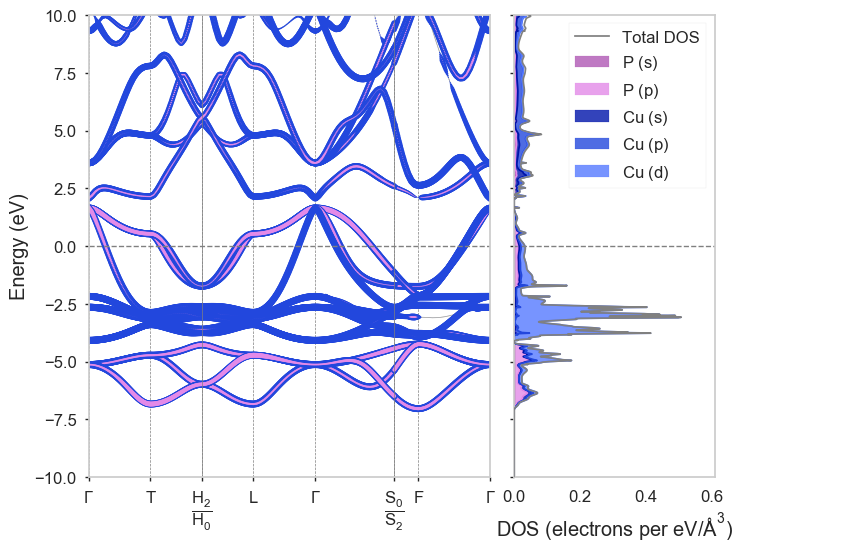

In [59]:
# write now displaying as svg is too taxing when there are many thousand points, so switch to png here 
# long-term solution is probably to rewrite pdis plotting to use variable line widths with variable zorder...
set_matplotlib_formats('png')
plot_spectral(
    '/u/fs1/afh41/Cu2P-bands-elec/CuP-Ir2P-OQMD_30622-CollCode640898',
    pdis_interpolation_factor=5,
  #  png=True
)
set_matplotlib_formats('png')

Using config from /u/fs1/me388/.matadorrc
Reordering bands based on local gradients...
Displaying plot...


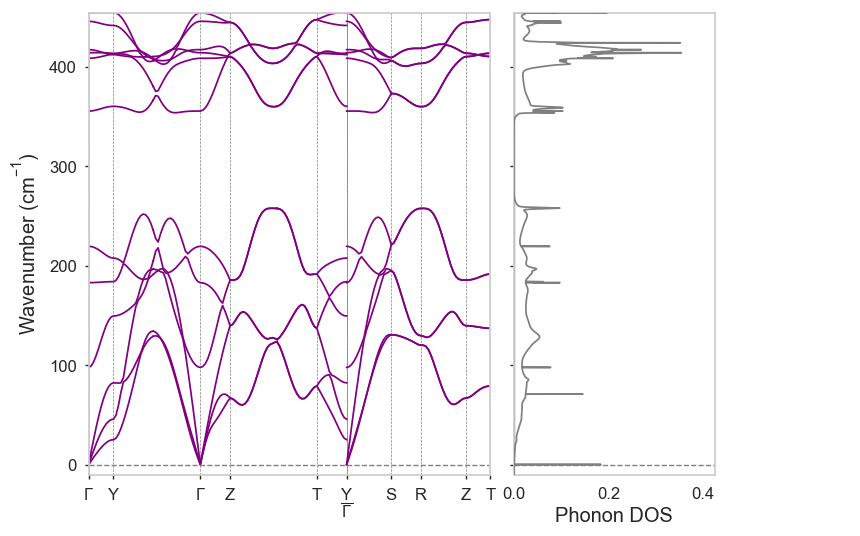

In [60]:
# this DOS is a bit weird?
plot_spectral(
    '/u/fs1/afh41/P-phonon/P-CollCode150873_prim-out_prim',
    phonons=True,
    band_colour='purple', 
   # png=True,
)

100%|██████████| 21/21 [00:00<00:00, 1040.87it/s]
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mappi

5 structures found within 0.0 eV of the hull, including chemical potentials.
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                 Source                  !?!  Pressure  Volume/fu  Hull dist.   Space group     Formula      # fu   Prov.  
                                               (GPa)     (Ang^3)   (meV/atom)  
───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
* Cu-OQMD_592441-CollCode43493_0[..]            xxx          95.6          0.0                   Cu          1     SWAPS  
* CuP-aw2v56-a_final_prim-out_prim              xxx         332.4          0.0                  Cu2P         1     AIRSS  
* CuP2-OQMD_6538-CollCode35282_0[..]             -0.00      391.8          0.0                  CuP2         4     SWAPS  
* Cu2P7-OQMD_6537-CollCode35281_[..]              0.00     1307.7          0.0                  Cu2P7 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

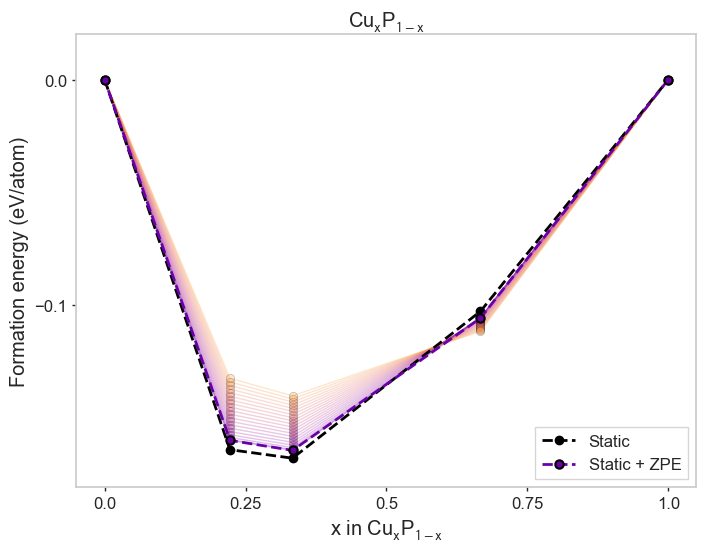

In [8]:
from matador.hull.hull_temperature import TemperatureDependentHull 
cursor, failures = castep2dict('/u/fs1/afh41/proj/test-done-from-athena/CuP/*.castep', db=False)
if failures:
    print(failures)

hull = TemperatureDependentHull(
    cursor=cursor,
    energy_key='total_energy_per_atom',
    species=['Cu','P']
)
ax = hull.plot_hull(show_points=True)
lims = ax.get_ylim()
ax.set_ylim(lims[0], 0.02);

In [64]:
# plot temperature vs. enthalpy for P and P_SCAN
from matador.orm.spectral import VibrationalDOS
P = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/P-CollCode150873_prim-out_prim.castep', db=False)[0])
P_SCAN = VibrationalDOS(castep2dict('/u/fs1/afh41/P-phonon/SCAN/P-CollCode150873_prim-out_prim.castep', db=False)[0])

Using config from /u/fs1/me388/.matadorrc
Using config from /u/fs1/me388/.matadorrc


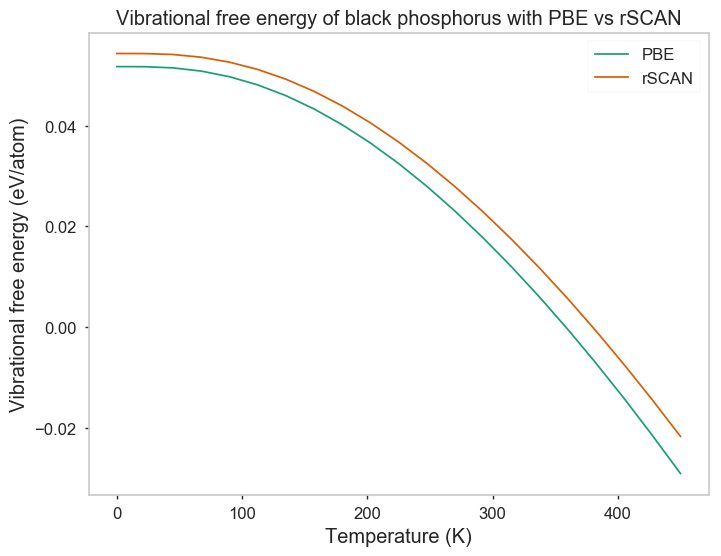

In [65]:
import numpy as np
temperatures = np.linspace(0, 450, 21)
fig, ax = plt.subplots()
ax.set_title('Vibrational free energy of black phosphorus with PBE vs rSCAN')
P.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': 'PBE'})
P_SCAN.plot_free_energy(temperatures=temperatures, ax=ax, line_kwargs={'label': 'rSCAN'})
ax.legend()

In [13]:
import numpy as np
Cu8P3 = {}
for doc in cursor:
    if doc['stoichiometry'][0][1] == 8.0:
         Cu8P3 = doc
S = 8.617333262145*.000010 * np.log(66) #0.00036 #config entropy of Cu8P3
print(S)
print(Cu8P3['thermo_free_energy'])
for temp in Cu8P3['thermo_free_energy']:
    print('F = ',Cu8P3['thermo_free_energy'][temp]-Cu8P3['smeared_free_energy'])
    print('F_config = ',(Cu8P3['thermo_free_energy'][temp]-Cu8P3['smeared_free_energy'])-S*temp)


0.00036103651165367843
{50.0: 0.662959, 145.0: 0.392562, 240.0: -0.155878, 335.0: -0.900329, 430.0: -1.791298, 525.0: -2.798394, 620.0: -3.901429, 715.0: -5.086101, 810.0: -6.341785, 905.0: -7.660277, 1000.0: -9.03507}
F =  28214.347325000002
F_config =  28214.32927317442
F =  28214.076928000002
F_config =  28214.02457770581
F =  28213.528488
F_config =  28213.441839237203
F =  28212.784037
F_config =  28212.663089768597
F =  28211.893068
F_config =  28211.73782229999
F =  28210.885972
F_config =  28210.696427831383
F =  28209.782937
F_config =  28209.559094362776
F =  28208.598265
F_config =  28208.34012389417
F =  28207.342581
F_config =  28207.05014142556
F =  28206.024089000002
F_config =  28205.697350956954
F =  28204.649296
F_config =  28204.288259488345
